In [1]:
!pip install kaggle

     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 78 kB 9.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=513749c2a63f3635f57d0b2e23f7274d8b09fb26bf06e50197e04ecbaa4d0f8b
  Stored in directory: /Users/naren/Library/Caches/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle


In [4]:
!kaggle competitions download -c digit-recognizer

 72%|███████████████████████████▎          | 11.0M/15.3M [00:00<00:00, 41.1MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 38.8MB/s]


In [7]:
!unzip digit-recognizer.zip 

^C


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(6)

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [4]:
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


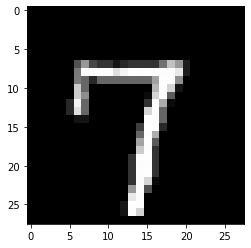

In [10]:
img = train_data.iloc[6, 1:].values.reshape(28, 28)
img = img / 255

plt.imshow(img, cmap='gray')


<AxesSubplot:>

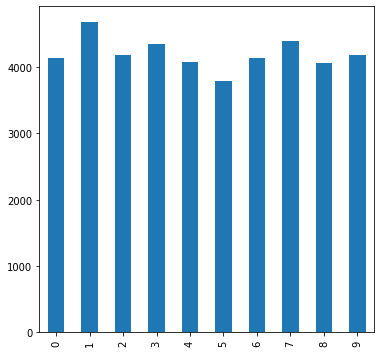

In [7]:
counts = train_data.label.value_counts().sort_index()

counts.plot.bar(figsize=(6, 6))

In [15]:
y = np.asarray(train_data.label)
X = np.asarray(train_data.iloc[:, 1:])

In [16]:
X = X / 255

In [17]:
X.shape

(42000, 784)

In [18]:
test_index = test_data.index

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X, y)

KNeighborsClassifier()

In [28]:
knn_clf.predict([X[6]])

AttributeError: 'list' object has no attribute 'shape'

In [24]:
X_test = test_data
X_test /= 255

X_test = np.asarray(X_test)
X_test.shape

(28000, 784)

In [32]:
from scipy.ndimage.interpolation import rotate

def img_augmenter(img) -> list:
    img = img.reshape(28, 28)
    rot_img_left = rotate(img, angle=10, reshape=False)
    rot_img_right = rotate(img, angle=-10, reshape=False)
    rot_img_left = rot_img_left.reshape(1, -1)
    rot_img_right = rot_img_right.reshape(1, -1)

    return [rot_img_left, rot_img_right]

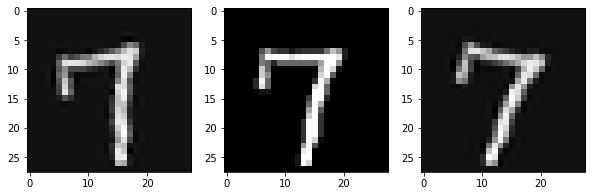

In [34]:
sample_img = X[6]
sample_out_left, sample_out_right = tuple(img_augmenter(sample_img))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))

#sample_out_left.shape
img_left = sample_out_left.reshape(28, 28)
ax[0].imshow(img_left, cmap='gray')

original_img = sample_img.reshape(28, 28)
ax[1].imshow(original_img, cmap='gray')

img_right = sample_out_right.reshape(28, 28)
ax[2].imshow(img_right, cmap='gray')

In [36]:
new_data = list()
new_labels = list()

for i, img in enumerate(X):
    label = y[i]
    new_data.extend(img_augmenter(img))
    new_labels.extend([label] * 2)
    
new_data = np.asarray(new_data)
new_labels = np.asarray(new_labels)

new_data = new_data.reshape(-1, 784)

print(new_data.shape)
print(new_labels.shape)

(84000, 784)
(84000,)


In [37]:
X_train = list(X)
X_train.extend(list(new_data))
X_train = np.asarray(X_train)

y_train = list(y)
y_train.extend(list(new_labels))
y_train = np.asarray(y_train)

In [39]:
print(X_train.shape)
print(y_train.shape)

(126000, 784)
(126000,)


In [38]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [40]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'n_neighbors': [3, 5, 6, 8], 'weights': ['uniform', 'distance']}
  ]

grid_search = RandomizedSearchCV(knn_clf, param_grid, n_iter=5, refit=True)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions=[{'n_neighbors': [3, 5, 6, 8],
                                         'weights': ['uniform', 'distance']}])

In [42]:
grid_search.best_params_

{'weights': 'distance', 'n_neighbors': 3}

In [43]:
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn_clf.fit(X_train, y_train)

y_test_pred = knn_clf.predict(X_test)

In [45]:
index = list(range(1, test_data.shape[0]+1))
pd.DataFrame(list(zip(index, y_test_pred)), columns=["ImageId", "Label"]).to_csv("submission.csv", index=False)